Predicting the Direction of the Supreme Court of the United States: A Machine Learning Approach
==================
  *  __Title__:Predicting the Direction of the Supreme Court of the United States: A Machine Learning Approach

  *  __Authors__: Roy Guy, Ziv Bogoslavsky, Miriam Horovicz 

## Paper Abstract
We construct a model designed to predict the voting behavior of the Supreme Court of the United States. Using only data available prior to the date of decision, our model correctly identifies 78% of the Court’s direction. We are using RandomForestClassifier as our model.
## Data Description
The data used in this paper is available from the [Supreme Court Database (SCDB)](http://scdb.wustl.edu/).


## Loading Data

In [7]:
import pandas as pd

data = pd.read_csv('/content/SCDB_2020_01_justiceCentered_Citation.csv', encoding='Windows-1252')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/SCDB_2020_01_justiceCentered_Citation.csv'

In [ ]:
data['dateDecision'] = pd.to_datetime(data['dateDecision'])

In [ ]:
filter_data = data[data["dateDecision"]> "2015-01-01"]
filter_data.shape

In [ ]:
data = filter_data

In [ ]:
data['Issue'].value_counts()

## Remove non relevant features 

In [ ]:
data = data.drop(columns = ['justice', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
                                        'usCite', 'sctCite', 'ledCite', 'lexisCite',
                                        'docket', 'caseName', 'petitionerState', 'respondentState',
                                        'adminActionState', 'caseOriginState',
                                        'caseSourceState', 'declarationUncon',
                                        'caseDispositionUnusual', 'partyWinning', 'voteUnclear',
                                        'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
                                        'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
                                        'splitVote','firstAgreement', 'secondAgreement',
                                        'dateArgument', 'dateRearg', 'petitioner', 'respondent',
                                        'term', 'caseDisposition', 'decisionDirection',
                                        'majVotes', 'minVotes', 'majority', 'vote', 'opinion',
                                        'precedentAlteration', 'issueArea','caseId','justiceName'])
data.shape

(3737, 15)

## Data Manipulation 

In [ ]:

columns_to_dummy = ['chief']
data = pd.get_dummies(data, columns = columns_to_dummy)
data.head()

,decisionType,naturalCourt,jurisdiction,adminAction,threeJudgeFdc,caseOrigin,caseSource,lcDisagreement,certReason,lcDisposition,lcDispositionDirection,issue,lawType,direction,chief_Roberts
77045,1,1704,1.0,NaN,0.0,46.0,28.0,0.0,12.0,2.0,1.0,30160.0,6.0,2.0,1
77046,1,1704,1.0,NaN,0.0,46.0,28.0,0.0,12.0,2.0,1.0,30160.0,6.0,2.0,1
77047,1,1704,1.0,NaN,0.0,46.0,28.0,0.0,12.0,2.0,1.0,30160.0,6.0,2.0,1
77048,1,1704,1.0,NaN,0.0,46.0,28.0,0.0,12.0,2.0,1.0,30160.0,6.0,2.0,1
77049,1,1704,1.0,NaN,0.0,46.0,28.0,0.0,12.0,2.0,1.0,30160.0,6.0,2.0,1


In [ ]:
data = data.dropna(axis=0, subset=['direction'])
data.shape

(3488, 15)

In [ ]:




data = data.fillna(0)

In [ ]:






data['direction'] = data['direction'].apply(lambda val: int(val))

In [ ]:
x = data.drop('direction',axis=1)
y = data['direction']





## Run Model

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
def results_plot_summary(y_true, y_scores, pos_label=1, labels = ['Negative', 'Positive'], labels_colors = ['r', 'b'], figsize = (24,6), metric_round = 3, bin_count = 10):
    from sklearn import metrics
    precision, recall, thresholds = metrics.precision_recall_curve(y_true, y_scores, pos_label=pos_label)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=pos_label)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=figsize)
    sns.lineplot(x=fpr, y=tpr, ax=ax1)
    ax1.set_title('Receiver Operating Characteristic')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax1.plot([0, 1], [0, 1])
    sns.lineplot(x=recall, y=precision, ax=ax2)
    ax2.set_title('Precision Recall Curve')
    ax2.set(xlabel='Recall', ylabel='Precision')
    sns.distplot(y_scores[y_true!=pos_label], bins = bin_count, kde=False, norm_hist=True, label=labels[0], color=labels_colors[0], ax=ax3)
    sns.distplot(y_scores[y_true==pos_label], bins = bin_count, kde=False, norm_hist=True, label=labels[1], color=labels_colors[1], ax=ax3)
    ax3.legend()
    ax3.set_title('Probabilities')
    ax3.set(xlabel='Score', ylabel='Density')

    plt.show()
    
def calc_metrics(y_true, y_pred, y_scores, pos_label = 1):
    output = {
        'precision'              : metrics.precision_score(y_true, y_pred),
        'recall'                 : metrics.recall_score(y_true, y_pred),
        'average_precision_score': metrics.average_precision_score(y_true, y_scores),
        'f1_score'               : metrics.f1_score(y_true, y_pred), 
        'roc_auc_score'          : metrics.roc_auc_score(y_true, y_scores)
    }
    return output

def conf_matrix_threshold(y_true, y_scores, th = 0.5, labels = [0, 1], labels_alias = ['Negative', 'Positive'], round_dec = 2):
    y_pred = np.where(y_scores >= th, labels[1], labels[0])
    conf_matrix = pd.DataFrame(
        metrics.confusion_matrix(y_true, y_pred), 
        index   = ['Actual ' + labels_alias[0]   , 'Actual ' + labels_alias[1]], 
        columns = ['Predicted ' + labels_alias[0], 'Predicted ' + labels_alias[1]]
    )
    specifity         = round(100*(conf_matrix.iloc[0,0]) / (conf_matrix.iloc[0,0] + conf_matrix.iloc[0,1]), round_dec)
    FPR               = round(100*(conf_matrix.iloc[0,1]) / (conf_matrix.iloc[0,1] + conf_matrix.iloc[0,0]), round_dec)
    recall            = round(100*(conf_matrix.iloc[1,1]) / (conf_matrix.iloc[1,0] + conf_matrix.iloc[1,1]), round_dec)
    precision         = round(100*(conf_matrix.iloc[1,1]) / (conf_matrix.iloc[0,1] + conf_matrix.iloc[1,1]), round_dec)
    accuracy          = round(100*(conf_matrix.iloc[1,1] + conf_matrix.iloc[0,0]) / (conf_matrix.iloc[0,0] + conf_matrix.iloc[0,1] + conf_matrix.iloc[1,0] + conf_matrix.iloc[1,1]), round_dec)
    balanced_accuracy = round((specifity + recall)/2, round_dec)  

    
    output = {
        'specifity'         : [specifity],
        'FPR'               : [FPR],
        'recall'            : [recall],
        'precision'         : [precision],
        'accuracy'          : [accuracy],
        'balanced_accuracy' : [balanced_accuracy]
    }
    return conf_matrix, output

## Model training and performance results 

--Model Performance Charts--



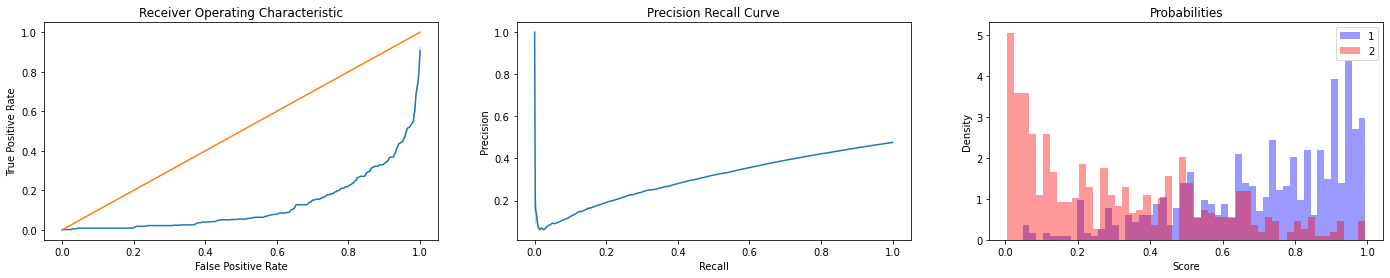

77376    1
80172    2
80729    1
78641    1
78115    1
        ..
79441    1
80063    1
78194    2
80265    2
80092    1
Name: direction, Length: 1152, dtype: int64
[0.12287816 0.99407238 0.36180673 ... 0.91212531 0.82632484 0.02013197]

--Confusion Matrix at Cutoff = 0.5--

          Predicted 1  Predicted 2
Actual 1          422          127
Actual 2          115          488

--Metrics at Cutoff = 0.5--

         specifity   FPR  recall  precision  accuracy  balanced_accuracy
Metrics       76.9  23.1    80.9       79.3      79.0               78.9


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.metrics as metrics

x   = x_train
y   = y_train
x_t = x_test
y_t = y_test


model_rf    = RandomForestClassifier(n_estimators = 2000, max_depth = 12)
model_rf.fit(x, y)

y_scores = model_rf.predict_proba(x_t)[:,1]
y_pred   = model_rf.predict(x_t)

# Print out the results
print('--Model Performance Charts--')
print()

results_plot_summary(y_test, y_scores, pos_label = 1, labels = [1, 2], labels_colors = ['b', 'r'], figsize = (24,4), metric_round = 4, bin_count = 50)

print(y_test)
print(y_scores)
th_conf = 0.5
print()
print(f'--Confusion Matrix at Cutoff = {th_conf}--')
print()
conf_matrix, metrics_at_target = conf_matrix_threshold(y_test, y_scores, th = th_conf, labels = [1, 2], labels_alias = ['1', '2'], round_dec = 1)
print(conf_matrix)
print()
print(f'--Metrics at Cutoff = {th_conf}--')
print()
print(pd.DataFrame(metrics_at_target, index=['Metrics']))

## Important Features 

In [ ]:
f_importance = pd.DataFrame({'Importance': model_rf.feature_importances_}, index = x_train.columns).sort_values('Importance', ascending=False)
f_importance.head(20)

,Importance
issue,0.186248
caseOrigin,0.163589
lcDispositionDirection,0.128509
caseSource,0.105836
certReason,0.081767
lawType,0.076315
lcDisposition,0.074187
naturalCourt,0.073844
adminAction,0.041144
decisionType,0.029768


## Tree Visualization 

In [ ]:
import warnings
from sklearn import tree
from dtreeviz.trees import dtreeviz
import numpy as np
import pdb
from sklearn.tree import DecisionTreeClassifier
warnings.filterwarnings("ignore", category=FutureWarning)


def draw_tree(X, y):
    model = DecisionTreeClassifier(max_depth=3)
    model.fit(X,y)
    viz = dtreeviz(model, 
                   X,
                   y,
                   target_name='direction',
                   feature_names=X.columns, 
                   class_names=["Liberal","Conservative"])
    return viz

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


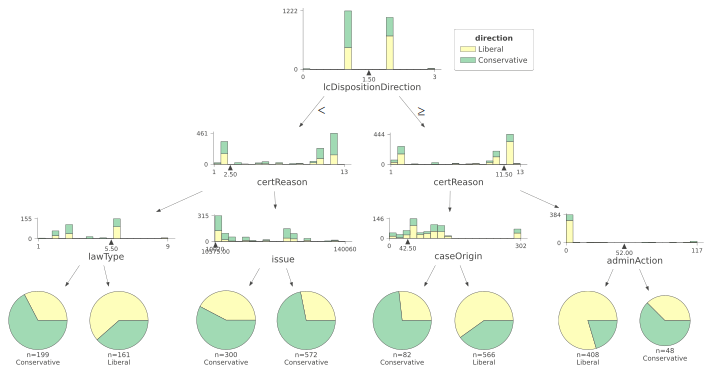

In [ ]:
draw_tree(x_train, y_train)

In [2]:
!pip install dash

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 1.0MB 9.0MB/s 
     |████████████████████████████████| 3.5MB 26.9MB/s 
     |████████████████████████████████| 194kB 47.4MB/s 
     |████████████████████████████████| 1.8MB 45.5MB/s 
     |████████████████████████████████| 358kB 46.5MB/s 
  Created wheel for dash: filename=dash-1.18.1-cp36-none-any.whl size=83681 sha256=54331dd8e14b1f3fe898840601837cd614fb67ac11e55ef86cbd7954908397b7
  Stored in directory: /root/.cache/pip/wheels/eb/56/fb/79b2169ce9fcb79753ec57a16abb8f0b7750b4c63d7eb3cea9
  Created wheel for dash-renderer: filename=dash_renderer-1.8.3-cp36-none-any.whl size=1013945 sha256=4447114a2b53bab2cfb937f869ee12a172d3950ab9046bb060afc0f7c8ce19c0
  Stored in directory: /root/.cache/pip/wheels/cf/2b/5f/0928a6d1b7ebf280f21a2e925f36d662e6ba83e00b82c6b6bf
  Created wheel for dash-core-components: filename=dash_core_components-1.14.1-cp36-none-any.whl size=3525927 sha256=2d28faa7f980b0c301dbf

In [2]:
!pip install dash

  Created wheel for dash: filename=dash-1.18.1-py3-none-any.whl size=83681 sha256=1d0c9b65c1d98dff26861744ad20ff27476f1d39f2008735bf96fdcad25a2ab2
  Stored in directory: c:\users\mhorovicz\appdata\local\pip\cache\wheels\c1\f0\dc\4d5f7c91c8f773dfde06e6ed6c0a45c8cf213336b963118741
  Created wheel for dash-renderer: filename=dash_renderer-1.8.3-py3-none-any.whl size=1013946 sha256=f5a5c62f6a0c191f36c669929317dda591a527ba23d8340ee496f94133bc0405
  Stored in directory: c:\users\mhorovicz\appdata\local\pip\cache\wheels\71\17\b0\8bebc086e55a01cf4036902b6ca05fce3fb4c7fd48dbd07717
  Created wheel for dash-core-components: filename=dash_core_components-1.14.1-py3-none-any.whl size=3525935 sha256=3b1ee4fa5279222c969596a0f7cf6b9c8a9ea3de33f3d6188fc3c7d4e1ba588c
  Stored in directory: c:\users\mhorovicz\appdata\local\pip\cache\wheels\ef\a4\3c\ceec876f847e7a9c24e5f95d76aa9c9a1ca64b3a67f0a81b41
  Created wheel for dash-html-components: filename=dash_html_components-1.1.1-py3-none-any.whl size=427900 

In [24]:
!pip install header

ERROR: Could not find a version that satisfies the requirement header (from versions: none)
ERROR: No matching distribution found for header


In [ ]:
import dash
from dash.dependencies import Input, Output
import dash_core_components as dcc
import dash_html_components as html

app = dash.Dash('App')

colors = {
    'background': 'grey',
    'text': '#7FDBFF'
}

app.layout = html.Div(style={'backgroundColor': colors['background']}, children=[
    html.H1(
        children='Predicting Supreme Court Direction',
        style={
            'textAlign': 'center',
            'color': colors['text'],
            'fontsize':60,
            'height':150
        }
    ),
  dcc.Tabs(id='tabs', value='tab-1', children=[
        dcc.Tab(label='Overview', value='Overview'),
        dcc.Tab(label='Predict', value='Predict'),
    ],style={'color': colors['text'],'backgroundColor': colors['background']}),
    
    html.Div(id='tabs-example-content')])

@app.callback(Output('tabs-example-content', 'children'),
              Input('tabs', 'value'))
def render_content(tab):
    if tab == 'Overview':
        return html.Div([
            html.H3('Tab content 1')
        ],style={'color': colors['text'],'backgroundColor': colors['background']})
    elif tab == 'Predict':
        return html.Div([
            html.H3('Tab content 2')
        ],style={'color': colors['text'],'backgroundColor': colors['background']})
    
app.css.append_css({'external_url': 'https://codepen.io/chriddyp/pen/bWLwgP.css'})

if __name__ == '__main__':
    app.run_server(debug=False)

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "App" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [30/Dec/2020 20:41:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:45] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:45] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:45] "GET /_favicon.ico?v=1.18.1 HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:45] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:47] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:48] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:41:49] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:43:27] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:43:28] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:43:30] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [30/Dec/2020 20:43:30] "POST /_dash-update-component H